In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import collections
import graphistry

from collections import Counter

%matplotlib inline

In [2]:
source1 = 'dataset/socfb-Mich67.txt' 
source2 = 'dataset/socfb-Caltech36.txt'

graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="klavan16", password="abcd2323")

In [3]:
# This function is used for reading the data and creating the graph.
# source: file location
# G: Graph
def create_graph(source):
    G = nx.Graph()
    with open(source) as file:
        lines = file.readlines()
        for line in lines:
            nodes = line.split()
            G.add_edge(nodes[0], nodes[1])
    return G

In [4]:
G1 = create_graph(source1)
G2 = create_graph(source2)

#### Graph Informations

In [5]:
def print_graph_info(G):
    ds = list(G.degree())
    
    print('Number of nodes: {}'.format(G.number_of_nodes()))
    print('Number of edges: {}'.format(G.number_of_edges()))
    
    degree = [int(i) for i in np.array(list(G.degree()))[:,1]]
    
    print('Max degree: {}'.format(np.max(degree)))
    print('Min degree: {}'.format(np.min(degree)))
    print('Average degree: {}'.format(np.mean(degree)))
    print('Median degree: {}'.format(np.median(degree)))

In [6]:
# people (nodes), friendship (edges).
print('\t "Graph1 information" ')
print_graph_info(G1)
print()
print('\t "Graph2 information" ')
print_graph_info(G2)

	 "Graph1 information" 
Number of nodes: 3748
Number of edges: 81903
Max degree: 419
Min degree: 1
Average degree: 43.704909284951974
Median degree: 30.0

	 "Graph2 information" 
Number of nodes: 769
Number of edges: 16656
Max degree: 248
Min degree: 1
Average degree: 43.3185955786736
Median degree: 36.0


In [7]:
graphistry.bind(source='src', destination='dst', node='nodeid').plot(G1)

In [8]:
graphistry.bind(source='src', destination='dst', node='nodeid').plot(G2)

#### Graph Adjacency Matrix

In [9]:
# This function is used to show adjacency matrix
# G: Graph
# ax: for show
# title: title of the adjacency matrix 
def show_adjacency_matrix(G, ax, title):
    A = nx.to_numpy_matrix(G, dtype=np.bool)
    
    ax.set_title(title)
    ax.imshow(A, cmap="Greys", interpolation="none")

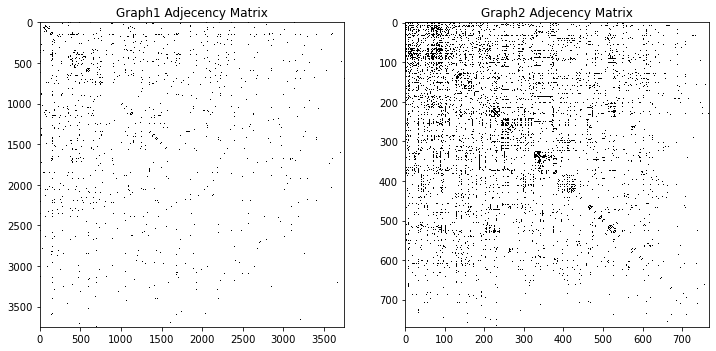

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
show_adjacency_matrix(G1, ax1, 'Graph1 Adjecency Matrix')
show_adjacency_matrix(G2, ax2, 'Graph2 Adjecency Matrix')

#### Graph Degree Distribution

In [11]:
# This function is used to plot degree distribution
# G: Graph
# ax: for show 
# title: title of the degree distribution
def plot_degree_dist(G, ax, title):
    dfreq = np.array(nx.degree_histogram(G)).astype('float')
    x = np.array(range(len(dfreq)))
    poly = np.polyfit(x, dfreq, 15)
    poly_y = np.poly1d(poly)(x)
    ax.plot(x, poly_y)
    ax.set_title(title)
    ax.set_xlabel("Degree")
    ax.set_ylabel("Frequency")

In [12]:
# This function is used to plot degree distribution
# G1: Graph1
# G2: Graph2
# ax: for show 
# title: title of the degree distribution
def plot_degree_dist_overlay(G_list, ax, title,highlightLast = False):
    for i,G in enumerate(G_list):
        dfreq = np.array(nx.degree_histogram(G)).astype('float')
        x = np.array(range(len(dfreq)))
        poly = np.polyfit(x, dfreq, 15)
        poly_y = np.poly1d(poly)(x)
        if highlightLast and i != len(G_list)-1:
            ax.plot(x, poly_y,linestyle = ":",alpha=0.7,linewidth=0.5)
        else:
            ax.plot(x, poly_y,linestyle='-',alpha=1,linewidth=2,color= 'blue' if highlightLast else None)
        
    ax.set_title(title)
    ax.set_xlabel("Degree")
    ax.set_ylabel("Frequency")

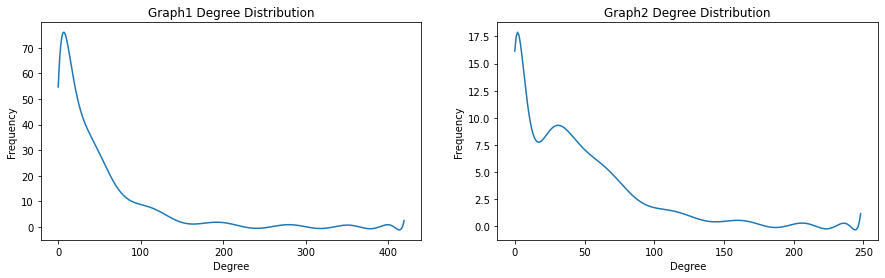

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
plot_degree_dist(G1, ax1, 'Graph1 Degree Distribution')
plot_degree_dist(G2, ax2, 'Graph2 Degree Distribution')

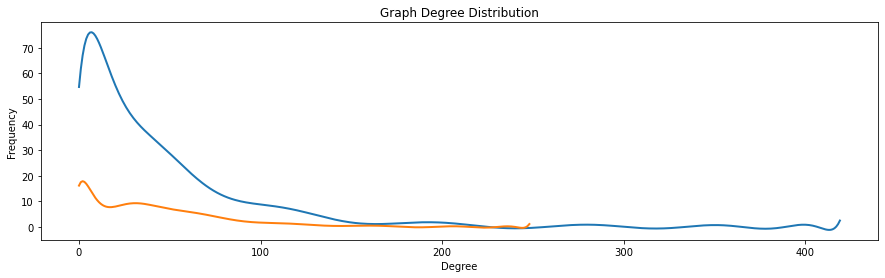

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
G_list = [G1, G2]
plot_degree_dist_overlay(G_list, ax, 'Graph Degree Distribution')

#### Random graph generation with given degree distribution

In [15]:
def get_degrees(G):
    degrees = [val for (node, val) in G.degree()]
    return degrees

In [16]:
def generate_random_graph(degrees, N):
    G_list = []
    
    for i in range(N):
        G = nx.expected_degree_graph(degrees, selfloops=False)
        G_list.append(G)
    return G_list

In [17]:
N = 100

In [18]:
degrees1 = get_degrees(G1)
G_list1 = generate_random_graph(degrees1, N)
G_list1.append(G1)

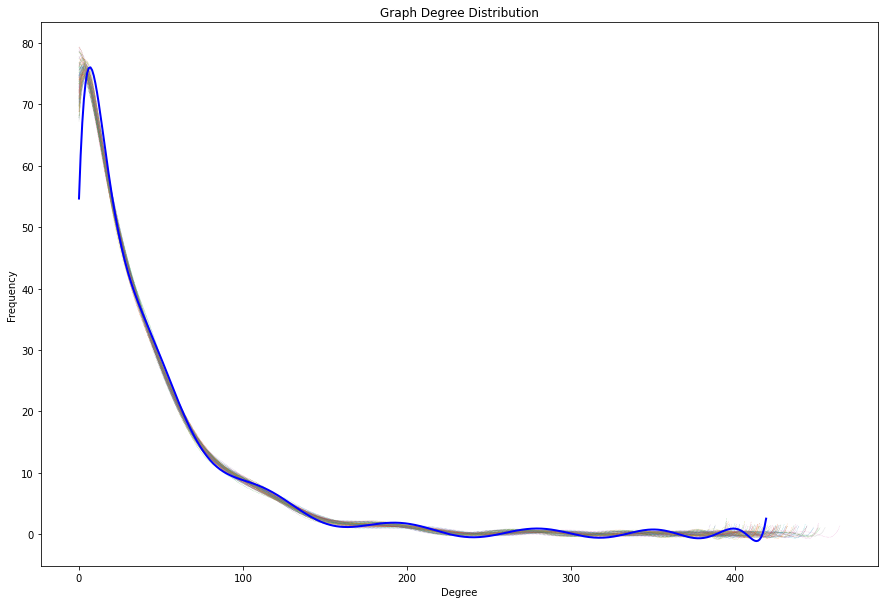

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plot_degree_dist_overlay(G_list1[:], ax, 'Graph Degree Distribution',True)

In [20]:
degrees2 = get_degrees(G2)
G_list2 = generate_random_graph(degrees2, N)
G_list2.append(G2)

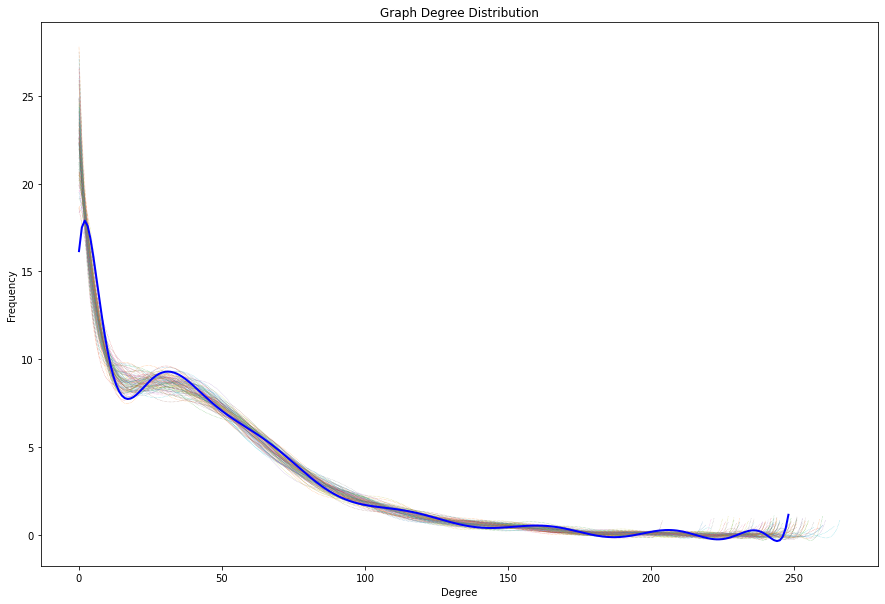

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plot_degree_dist_overlay(G_list2[:], ax, 'Graph Degree Distribution',True)

#### Rich club

In [22]:
# This function is used to plot rich club coefficient
# G: Graph
# ax: for show
def plot_rc_coefficient(G, ax):
    dict_ = {}
    rcc = nx.rich_club_coefficient(G, normalized=False)
    
    for key, val in enumerate(rcc):
        degree = G.degree[str(key + 1)]
        
        if degree in dict_:
            data = dict_[degree]
            data['val'] += val
            data['cnt'] += 1
            dict_[degree] = data
        else:
            dict_[degree] = {'val': val, 'cnt': 1}
    
    result = {}
    for key, value in enumerate(dict_):
        data = dict_[value]
        
        result[value] = data['val'] / data['cnt']
    
    items = result.items()
    result = sorted(items)
    
    keys = [data[0] for data in result]
    values = [data[1] for data in result]
 
    poly = np.polyfit(keys, values, 15)
    poly_y = np.poly1d(poly)(keys)
    
    ax.plot(keys, poly_y)
    ax.set_xlabel("Node Degree")
    ax.set_ylabel("Average Rich Club Coefficient")

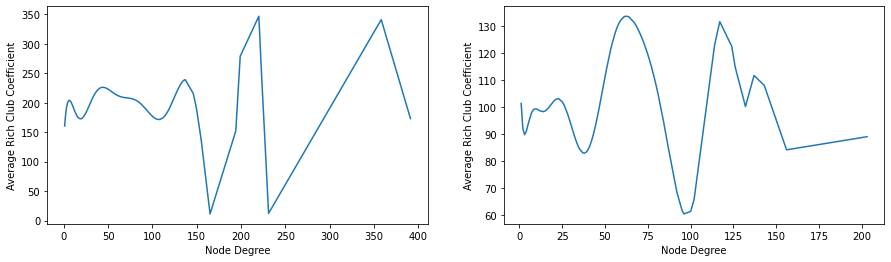

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
plot_rc_coefficient(G1, ax1)
plot_rc_coefficient(G2, ax2)

In [24]:
#c = nx.communicability(G2)
#c